# Third party commercial data

The aim of this notebook is to guide you how to get Very High Resolution Satellite (VHRS) data using Sentinelhub and eo-learn. Price for commercial data is described there https://www.sentinel-hub.com/pricing/.

The workflow for agriculture purposes is as follows :

1) Read shapefile that represent you field (boundaries or microplots)

2) Extract Sentinel-2 data and compute averaged NDVI time series to get a summary of the season vegetation dynamic.

3) Get the index of time when NDVI is maximum (season's peak) and add +/- one month to this date to get the time period for VHRS data extraction.

4) Extract VHRS data. If provider is Airbus, you can apply pansharpening algorithms to get the spatial resolution from the panchromatic band.

5) Preprocess and save the data.

6) Optional : intersects pixels with trial microplots polygons to get a value of NDVI for each microplot.

## Set your working environment

### Import the packages

In [54]:
import warnings
warnings.filterwarnings("ignore")

import glob


import geopandas as gpd

import os
import numpy as np

import matplotlib.pyplot as plt


from importlib import reload

from eocrops.input import utils_sh as utils_sh
from eocrops.input import sentinel2 as sentinel2
from eocrops.input import vhrs as vhrs
from eocrops.tasks import preprocessing as preprocessing

### Read your vector file

In [33]:
dir_path = os.path.dirname(os.getcwd())
print(dir_path)
#read microplot data
shapefile_input = gpd.read_file(os.path.join(dir_path, './examples/layers/POLYGON.shp'))


/home/s999379/git-repo/eo-crops


In [72]:
api =''
client_id =''
client_secret =''
config = utils_sh.config_sentinelhub_cred(api, client_id, client_secret)
#Provide here your planet API key 
config.planet_key = ''

### Extract S2 data

In [39]:
time_period = ('2020-02-01', '2020-10-30')

In [40]:
patch = sentinel2.workflow_instructions_S2L2A(**kwargs,
                                              coverage_predicate=0.5,
                                              interpolation={'interpolate' : True,
                                                             'period_length' : 8})  # you can add period_length in the dictionary to resample


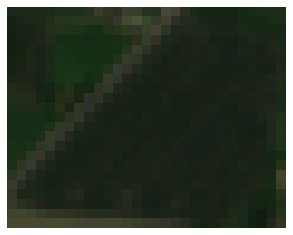

In [43]:
#RGB
plt.figure(figsize=(5, 5))
plt.imshow(np.clip(patch.data['BANDS-S2-L2A'][15][..., [2, 1, 0]]*2.5, 0, 1), vmin=0, vmax=1);
plt.axis(False);
plt.show()

In [202]:
preprocessing = reload(preprocessing)
#Mask out pixels that are oustide the polygon for visualisation and apply a binary erosion with radius = 1 to keep only pure pixels
masking = preprocessing.MaskPixels(["NDVI"])
patch = masking.execute(patch, erosion = 1)

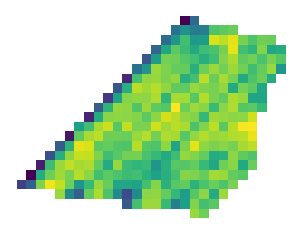

In [203]:
#NDVI
plt.figure(figsize=(5, 5))
plt.imshow(patch.data['NDVI'][15].squeeze());
plt.axis(False);
plt.show()

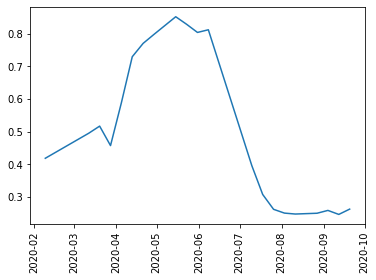

In [49]:
#LAI Time Series from masked field
variable = 'NDVI'
stats_df = preprocessing.get_time_series_profile(patch = patch, 
                                                 variable = variable, 
                                                 mask_name = 'MASK', 
                                                 function = np.nanmean)

plt.plot(patch.timestamp, stats_df[variable])
plt.xticks(rotation=90)
plt.show()

In [206]:
#Peak of the season is at 15/05 
time_max_index = np.nanargmax(stats_df[variable])
patch.timestamp[np.nanargmax(stats_df[variable])]

datetime.datetime(2020, 3, 28, 0, 0)

## VHRS data

In [128]:
#Define the time period
time_period_vhrs = ('2020-04-15', '2020-06-15')
#Define the workflow
download_workflow = vhrs.DownloadVHRSSentinelHub(shapefile=shapefile_input,
                                                 time_stamp = time_period_vhrs,
                                                 config = config,
                                                 maxCloudCoverage=10)

### Extract Planetscope data

In [133]:
#Define the provider as follows for Planetscope
provider_planet = ('PLANET', 'PSScene4Band')
#You can retrieve order id and collection ID on your SH account (https://apps.sentinel-hub.com/dashboard/#/tpdi) instead of doing a request again
order_id, collection_id = '	2f900fad-1f5e-4a46-b6da-327012d400e1', '79a1a2a9-ccf8-4e1f-8f42-9d854bf1dca9'

In [130]:
#Define the workflow to get your order_id and collection_id. It can be also be retrieved in your SH account in https://apps.sentinel-hub.com/dashboard/#/tpdi
order_id, results = download_workflow.execute_query(provider_planet, name_query='Example Planet')

b'{"sub":"6c2887da-a213-462e-a10c-fcb94e066dc9","aud":"07ae5fb1-ea68-4da0-9574-ea6978ead834","jti":"3bd9ec08-a159-4e7d-9e5f-a9ef2f5bb0b8","exp":1643712934,"name":" ","email":"johann.desloires@inrae.fr","given_name":"","family_name":"","sid":"e79e4f71-3649-4c29-af01-83fe1122789d","org":"3d31397f-770a-4f98-9358-84e918491745","did":1,"aid":"8f176e67-7f79-41d7-afae-901872621c07","d":{"1":{"ra":{"rag":7},"t":14001}},"active":true}'
7802e29a-cf4e-49bb-8c31-1977db377682
1.4870982763449545
CREATED


In [102]:
#You can access to all the meta data in results.
len(results['features'])

24

In [ ]:
#Check the status of the order. Image will not be available 
collection_id = download_workflow.confirm_order(order_id)

In [163]:
#While the statut is "RUNNING", you should wait that you data is ingested in your SH account. The output of this cell must be "DONE" before your get access to the data (~ 2-5 minutes)
download_workflow.check_status(order_id)

b'{"sub":"6c2887da-a213-462e-a10c-fcb94e066dc9","aud":"07ae5fb1-ea68-4da0-9574-ea6978ead834","jti":"ccfeacfe-22bd-4850-993c-36d404ceb598","exp":1643717245,"name":" ","email":"johann.desloires@inrae.fr","given_name":"","family_name":"","sid":"4127fd5e-26d0-43bf-8280-cceff506c6d4","org":"3d31397f-770a-4f98-9358-84e918491745","did":1,"aid":"8f176e67-7f79-41d7-afae-901872621c07","d":{"1":{"ra":{"rag":7},"t":14001}},"active":true}'


'DONE'

In [134]:
eopatch_planet = download_workflow.get_data(order_id = order_id,
                                            collection_id = collection_id,
                                            provider = provider,
                                            resolution = 3)

In [ ]:
#Reset the download_workflow if you would like to launch new orders. It is a way to prevent to download multiple times the same image and consume credits.
download_workflow.reset_workflow()

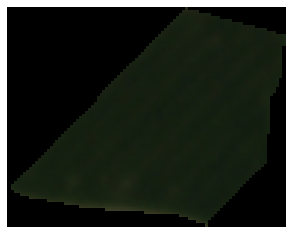

In [148]:
plt.figure(figsize=(5, 5))
plt.imshow(np.clip(eopatch_planet['data']['BANDS'][..., [2, 1, 0]][7,], 0, 1));
plt.axis(False);
plt.show()

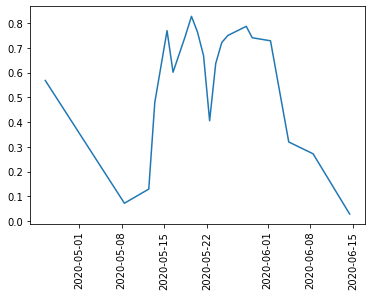

In [142]:
#LAI Time Series from masked field
variable = 'NDVI'
stats_df = preprocessing.get_time_series_profile(patch = eopatch_planet, 
                                                 variable = variable, 
                                                 mask_name = 'MASK', 
                                                 function = np.nanmean)

plt.plot(eopatch_planet.timestamp, stats_df[variable])
plt.xticks(rotation=90)
plt.show()

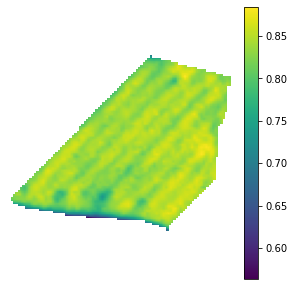

In [147]:
time_peak = np.nanargmax(stats_df[variable])
plt.figure(figsize=(5, 5))
plt.imshow(eopatch_planet.data['NDVI'][time_peak,].astype(float))
plt.colorbar()
plt.axis(False);
plt.show()

If you would like to save the EOPatch, you can 
- call the method .save (e.g. eopatch_spot.save(your_path)) from your EOPatch to save the corresponding npys
- save .tif images using ExportToTiffTask from eo-learn https://eo-learn.readthedocs.io/en/latest/eolearn.io.local_io.html#eolearn.io.local_io.ExportToTiffTask

### Extract AIRBUS SPOT data

In [165]:
#Define the provider as follows for Planetscope
provider_spot = ('AIRBUS', 'SPOT')
#can be also be retrieved in your SH account in https://apps.sentinel-hub.com/dashboard/#/tpdi
order_id_spot, collection_id_spot = '222331e9-d8d3-4e2f-959c-e292a665b214', '6458a2f4-70fb-4986-bb90-1b3aeaeaca25'

In [118]:
#Define the workflow to get your order_id and meta data.  
order_id_spot, results_spot = download_workflow.execute_query(provider_spot, name_query='example spot')

b'{"sub":"6c2887da-a213-462e-a10c-fcb94e066dc9","aud":"07ae5fb1-ea68-4da0-9574-ea6978ead834","jti":"6bb838ab-4015-4091-8522-193491e5823f","exp":1643712725,"name":" ","email":"johann.desloires@inrae.fr","given_name":"","family_name":"","sid":"40ae4dbc-b655-454e-bdf3-13202b360bf6","org":"3d31397f-770a-4f98-9358-84e918491745","did":1,"aid":"8f176e67-7f79-41d7-afae-901872621c07","d":{"1":{"ra":{"rag":7},"t":14001}},"active":true}'
cbd4ae1e-e9a4-4838-add5-7ac99a1f2bd6
2.5
CREATED


In [120]:
collection_id_spot = download_workflow.confirm_order(order_id_spot)

RUNNING


In [161]:
#While the statut is "RUNNING", you should wait that you data is ingested in your SH account. The output of this cell must be "DONE" before your get access to the data (~ 2-5 minutes)
download_workflow.check_status(order_id_spot)

b'{"sub":"6c2887da-a213-462e-a10c-fcb94e066dc9","aud":"07ae5fb1-ea68-4da0-9574-ea6978ead834","jti":"41f1d0ad-5272-4409-a1d7-945c4760846f","exp":1643717125,"name":" ","email":"johann.desloires@inrae.fr","given_name":"","family_name":"","sid":"2209ace6-eaa2-497d-aa6c-1f2a72db3a5d","org":"3d31397f-770a-4f98-9358-84e918491745","did":1,"aid":"8f176e67-7f79-41d7-afae-901872621c07","d":{"1":{"ra":{"rag":7},"t":14001}},"active":true}'


'RUNNING'

In [166]:
#Apply pansharpenning method to project native bands (VIS + NIR) at 6m into the panchromatic resolution (1.5). You need to have OrfeoToolbox installed in your computer, available for free on https://www.orfeo-toolbox.org/CookBook/Installation.html.
eopatch_spot = download_workflow.get_data(order_id = order_id_spot,
                                          collection_id = collection_id_spot,
                                          provider = provider_spot,
                                          resolution = 1.5,
                                          pansharpen = True,
                                          otb_path='/home/s999379/git-repo/OTB-7.4.0-Linux64/bin')

In [ ]:
#Reset the download_workflow method if you would like to execute new queries. 
# t is a way to prevent to download multiple times the same image and consume credits for nothing.
download_workflow.reset_workflow()

In [168]:
eopatch_spot.timestamp 

[datetime.datetime(2020, 4, 15, 10, 55, 52, 100000),
 datetime.datetime(2020, 5, 18, 10, 52, 42, 100000),
 datetime.datetime(2020, 6, 6, 10, 54, 50, 200000)]

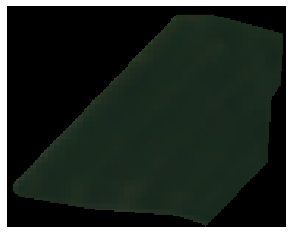

In [188]:
plt.figure(figsize=(5, 5))
plt.imshow(np.clip(eopatch_spot['data']['BANDS'][..., [2, 1, 0]][1,], 0, 1));
plt.axis(False);
plt.show()


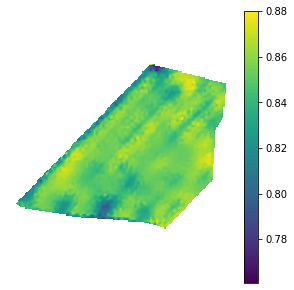

In [197]:
plt.figure(figsize=(5, 5))
plt.imshow(eopatch_spot.data['NDVI'][1,].astype(float), vmax = 0.88)
plt.colorbar()
plt.axis(False);
plt.show()

If you would like to save the EOPatch, you can 
- call the method .save (e.g. eopatch_spot.save(your_path)) from your EOPatch to save the corresponding npys
 - save .tif images using ExportToTiffTask from eo-learn https://eo-learn.readthedocs.io/en/latest/eolearn.io.local_io.html#eolearn.io.local_io.ExportToTiffTask

### Extract AIRBUS Pleaides data

Airbus Pleiades have a Panchromatic band at 0.5m and VIS-NIR at 1.5m. On SH, the price is roughly 10€ for 1km2 of order, with a minimal order of 0.25km2 (2€50).

In [174]:
#Define the provider as follows for Planetscope
provider_pleaides = ('AIRBUS', 'PHR')
#In case, you can use as follows to run the example instead of ordering again data to avoid to run the order and consume credits for nothing
order_id_pleiades, collection_id_pleaides = 'e7f5c398-0d23-4f9d-a6a8-03b2b0632554', '9eb3a890-7984-46bb-970d-db30ad5a4209'

In [154]:
#Define the workflow to get your order_id and collection_id. It can be also be retrieved in your SH account in https://apps.sentinel-hub.com/dashboard/#/tpdi
order_id_pleiades, results_pleiades = download_workflow.execute_query(provider_pleaides, name_query='example pleaides')

b'{"sub":"6c2887da-a213-462e-a10c-fcb94e066dc9","aud":"07ae5fb1-ea68-4da0-9574-ea6978ead834","jti":"dbf7ea0f-6f74-4e6d-ae03-1b5455a6034c","exp":1643715904,"name":" ","email":"johann.desloires@inrae.fr","given_name":"","family_name":"","sid":"b49cfd00-51a0-45f9-91a3-6707bf5fe210","org":"3d31397f-770a-4f98-9358-84e918491745","did":1,"aid":"8f176e67-7f79-41d7-afae-901872621c07","d":{"1":{"ra":{"rag":7},"t":14001}},"active":true}'
e7f5c398-0d23-4f9d-a6a8-03b2b0632554
0.25
CREATED


In [155]:
collection_id_pleaides = download_workflow.confirm_order(order_id_pleiades)

RUNNING


In [160]:
#While the statut is "RUNNING", you should wait that you data is ingested in your SH account. The output of this cell must be "DONE" before your get access to the data (~ 2-5 minutes)
download_workflow.check_status( order_id_pleiades)


b'{"sub":"6c2887da-a213-462e-a10c-fcb94e066dc9","aud":"07ae5fb1-ea68-4da0-9574-ea6978ead834","jti":"2eaec86d-af61-4b97-8b5c-dcced894e3b3","exp":1643717164,"name":" ","email":"johann.desloires@inrae.fr","given_name":"","family_name":"","sid":"c86af45c-7440-47c8-b819-584ca6ef0b57","org":"3d31397f-770a-4f98-9358-84e918491745","did":1,"aid":"8f176e67-7f79-41d7-afae-901872621c07","d":{"1":{"ra":{"rag":7},"t":14001}},"active":true}'


'RUNNING'

In [175]:
#Apply pansharpenning method to project native bands (VIS + NIR) at 6m into the panchromatic resolution (1.5). You need to have OrfeoToolbox installed in your computer, available for free on https://www.orfeo-toolbox.org/CookBook/Installation.html.
eopatch_pleaides = download_workflow.get_data(order_id = order_id_pleiades,
                                          collection_id = collection_id_pleaides,
                                          provider = provider_pleaides,
                                          resolution = 0.5,
                                          pansharpen = True, #Apply pansharpenning method to project native bands (VIS + NIR) at 1.5m into the panchromatic resolution (0.5). You need to have OrfeoToolbox installed in your computer, available for free on https://www.orfeo-toolbox.org/CookBook/Installation.html.
                                          otb_path='/home/s999379/git-repo/OTB-7.4.0-Linux64/bin')

In [187]:
eopatch_pleaides.timestamp

[datetime.datetime(2020, 6, 6, 11, 21, 32, 600000)]

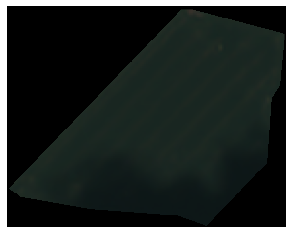

In [178]:
plt.figure(figsize=(5, 5))
plt.imshow(np.clip(eopatch_pleaides['data']['BANDS'][..., [2, 1, 0]][0,], 0, 1));
plt.axis(False);
plt.show()


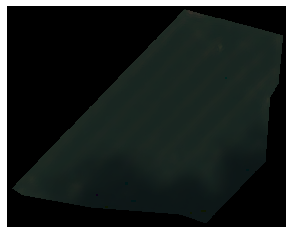

In [179]:
plt.figure(figsize=(5, 5))
plt.imshow(np.clip(eopatch_pleaides['data']['BANDS-PAN'][..., [2, 1, 0]][0,], 0, 1));
plt.axis(False);
plt.show()

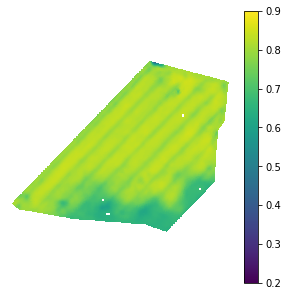

In [185]:
plt.figure(figsize=(5, 5))
plt.imshow(eopatch_pleaides.data['NDVI'][0,].astype(float),vmin = 0.2, vmax = 0.9)
plt.colorbar()
plt.axis(False);
plt.show()

In [ ]:
If you would like to save the EOPatch, you can 
- call the method .save (e.g. eopatch_spot.save(your_path)) from your EOPatch to save the corresponding npys
- save .tif images using ExportToTiffTask from eo-learn https://eo-learn.readthedocs.io/en/latest/eolearn.io.local_io.html#eolearn.io.local_io.ExportToTiffTask